In [ ]:
%matplotlib inline
import pyemma
import matplotlib
import pyemma.coordinates as coor
from pyemma.util.contexts import settings
import deeptime as dt
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdtraj

In [ ]:
pdb ="coor-exct_3335k_e1-1onlyprotein.pdb"
files ="333without.dcd"

In [ ]:
print(pdb)
print(files)

coor-exct_3335k_e1-1onlyprotein.pdb
333without.dcd


In [ ]:
group_TM1b = [[i + 1246 for i in range(248)]]
group_TM10=[[i + 7274 for i in range(217) ]]
group_TM1a=[[i + 1025 for i in range(208) ]]
group_TM6b=[[i + 5066 for i in range(157) ]]
group_TM6a=[[i + 4816 for i in range(219) ]]


distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_group_COM(group_TM1b)
distances_feat.add_group_COM(group_TM10)
distances_feat.add_group_COM(group_TM1a)
distances_feat.add_group_COM(group_TM6b)
distances_feat.add_group_COM(group_TM6a)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels = ['backbone atom\ndistances']

/home/lbcb/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:194: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/lbcb/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [ ]:
distances_feat.describe()

['COM-x of atom group [[1246 1247 1248]..[1491 1492 1493]] ',
 'COM-y of atom group [[1246 1247 1248]..[1491 1492 1493]] ',
 'COM-z of atom group [[1246 1247 1248]..[1491 1492 1493]] ',
 'COM-x of atom group [[7274 7275 7276]..[7488 7489 7490]] ',
 'COM-y of atom group [[7274 7275 7276]..[7488 7489 7490]] ',
 'COM-z of atom group [[7274 7275 7276]..[7488 7489 7490]] ',
 'COM-x of atom group [[1025 1026 1027]..[1230 1231 1232]] ',
 'COM-y of atom group [[1025 1026 1027]..[1230 1231 1232]] ',
 'COM-z of atom group [[1025 1026 1027]..[1230 1231 1232]] ',
 'COM-x of atom group [[5066 5067 5068]..[5220 5221 5222]] ',
 'COM-y of atom group [[5066 5067 5068]..[5220 5221 5222]] ',
 'COM-z of atom group [[5066 5067 5068]..[5220 5221 5222]] ',
 'COM-x of atom group [[4816 4817 4818]..[5032 5033 5034]] ',
 'COM-y of atom group [[4816 4817 4818]..[5032 5033 5034]] ',
 'COM-z of atom group [[4816 4817 4818]..[5032 5033 5034]] ']

In [ ]:
tica = pyemma.coordinates.tica(distances_data, lag=15)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

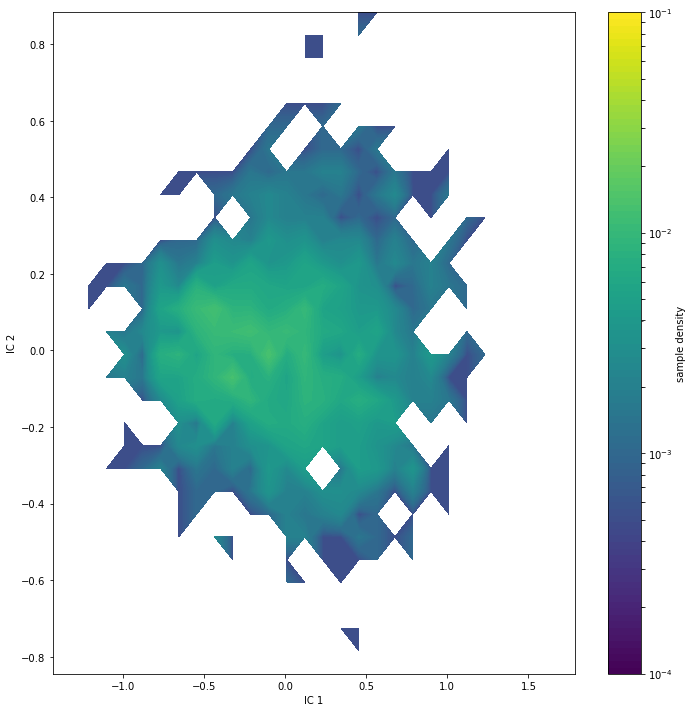

In [ ]:
fig, axes = plt.subplots( 1, figsize=(10, 10))

pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes, logscale=True, nbins=30)
axes.set_xlabel('IC 1')
axes.set_ylabel('IC 2')
fig.tight_layout()

In [ ]:
pca = pyemma.coordinates.pca(distances_data, dim=2)
pca_output = pca.get_output()
pca_concatenated = np.concatenate(pca_output)

In [ ]:
pca2=pca_concatenated[:, :2].T
np.savetxt(r'/home/lbcb/pca_to_graficar/ser333_pca_MDeN.txt',pca2)

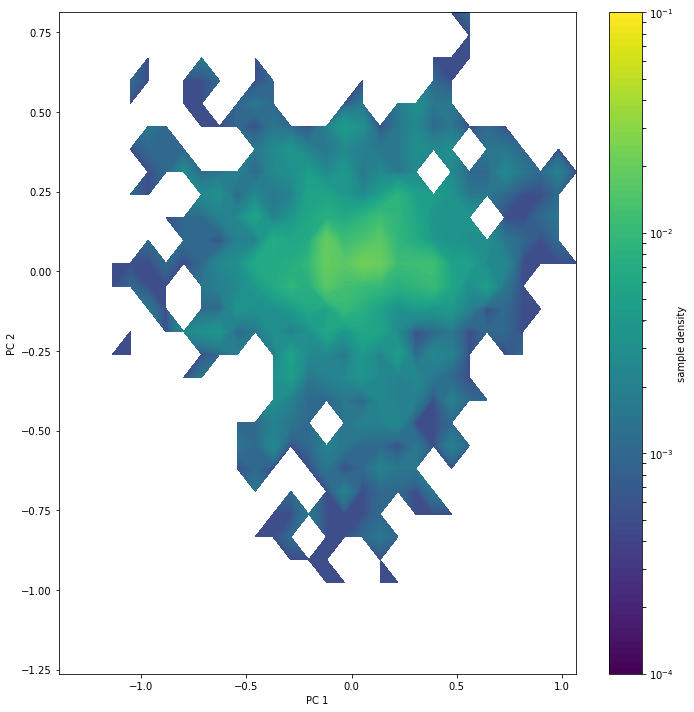

In [ ]:
fig, axes = plt.subplots( 1, figsize=(10, 10))

pyemma.plots.plot_density(*pca_concatenated[:, :2].T, ax=axes, logscale=True, nbins=30)
axes.set_xlabel('PC 1')
axes.set_ylabel('PC 2')
fig.tight_layout()

/home/lbcb/anaconda3/lib/python3.8/site-packages/pyemma/plots/plots2d.py:251: UserWarning: logscale=True is not an allowed optional parameter and will be ignored
  _warn(


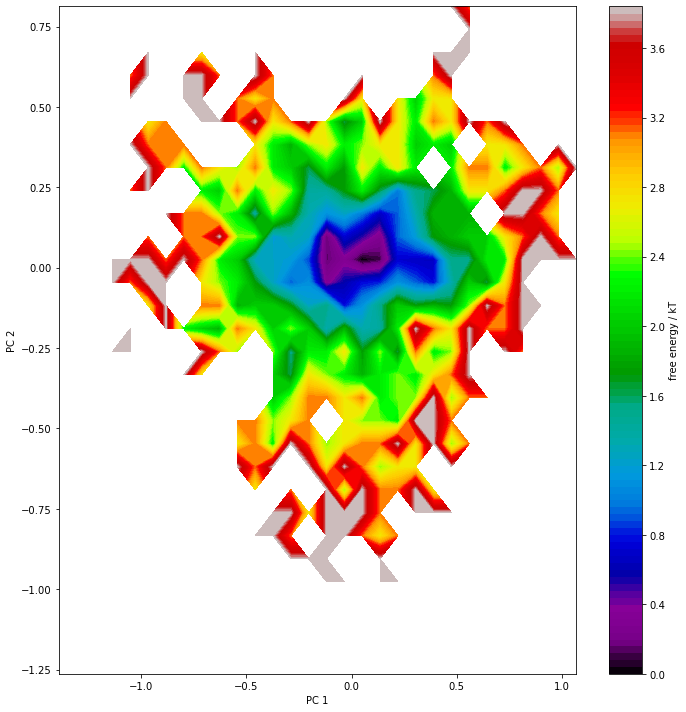

In [ ]:
fig, axes = plt.subplots( 1, figsize=(10, 10))

pyemma.plots.plot_free_energy(*pca_concatenated[:, :2].T, ax=axes, logscale=True, nbins=30)
axes.set_xlabel('PC 1')
axes.set_ylabel('PC 2')
fig.tight_layout()

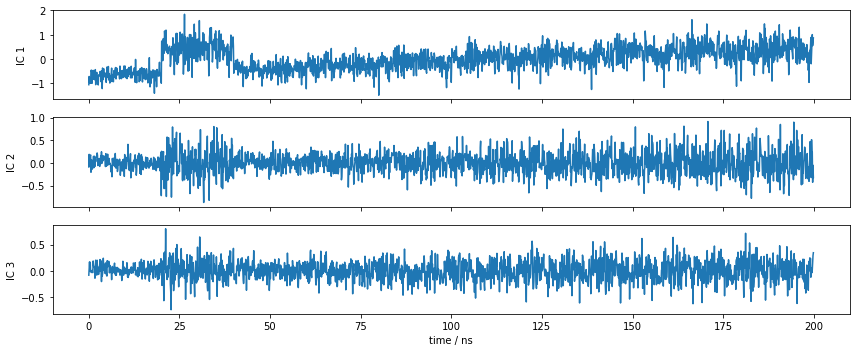

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

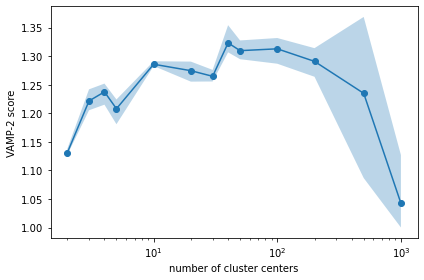

In [ ]:
n_clustercenters = [2,3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 500,1000]

scores = np.zeros((len(n_clustercenters), 3))
for n, k in enumerate(n_clustercenters):
    for m in range(3):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=5000000, stride=1)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs,3)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(2, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

In [ ]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=3, max_iter=20000000, stride=1, fixed_seed=0)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

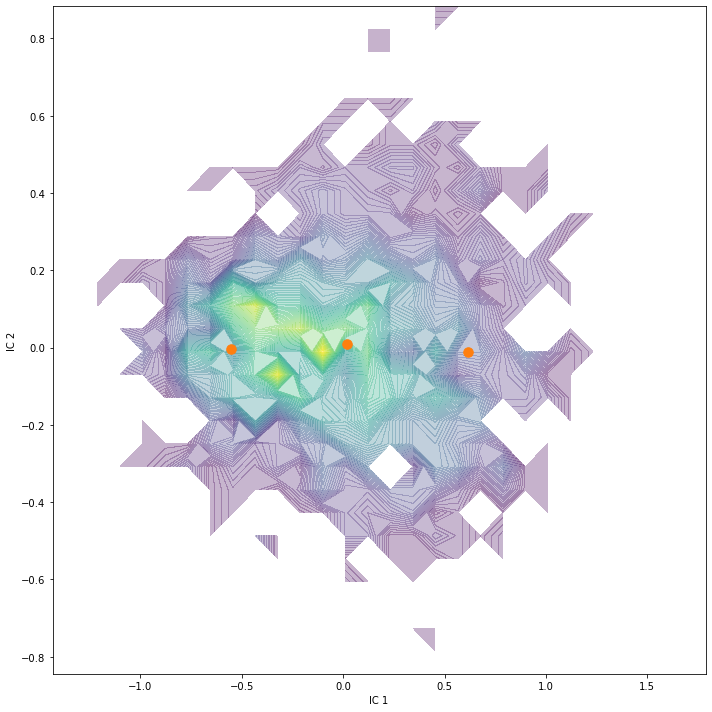

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3, nbins=30)
ax.scatter(*cluster.clustercenters[:, :2].T, s=90, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

23-05-21 21:09:02 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[300] WARNING  Changed user setting nits to the number of available timescales nits=2


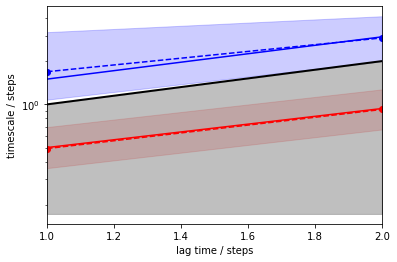

In [ ]:
its = pyemma.msm.its(cluster.dtrajs, lags=2, nits=9, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='steps', dt=1);

In [ ]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=2, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


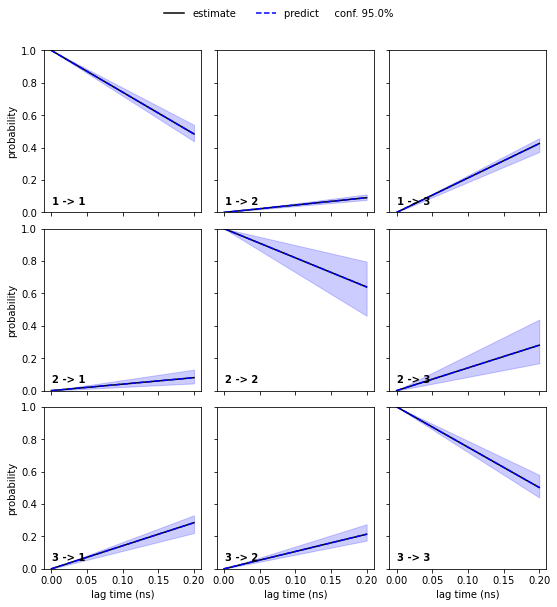

In [ ]:
nstates = 3
cktest = msm.cktest(nstates, mlags=2)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

In [ ]:
msm.stationary_distribution

array([0.31318902, 0.27545094, 0.41136004])

In [ ]:
msm.timescales()

array([0.29502976, 0.09352975])

In [ ]:
P=msm.P
pyemma.msm.markov_model(P, dt_model='1 step')

MSM(P=array([[0.63968, 0.07986, 0.28045],
       [0.0908 , 0.48405, 0.42514],
       [0.21352, 0.28468, 0.5018 ]]),
  dt_model='1 step', neig=3, pi=array([0.31319, 0.27545, 0.41136]),
  reversible=True)

In [ ]:
msm.timescales()

array([0.29502976, 0.09352975])

The disks represent the five discrete states, with areas proportional to the stationary probability of each state. The labels 0-4 plotted within disks are just indexes that will be used to refer to states. The arrows represent transitions between states, with their thickness proportional to the transition probability

(<Figure size 864x767.619 with 1 Axes>,
 array([[0.        , 0.88844837],
        [0.50002481, 0.44425211],
        [1.        , 0.        ]]))

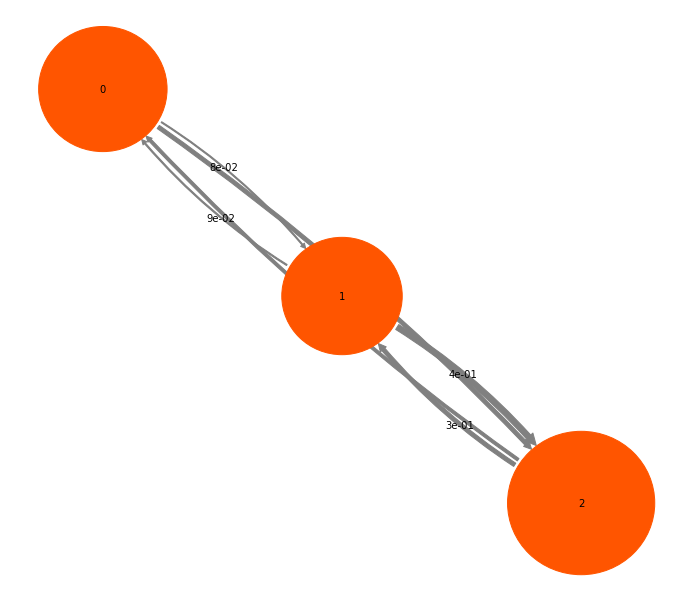

In [ ]:
pyemma.plots.plot_markov_model(msm)

In [ ]:
msm.metastable_sets

[array([1]), array([0]), array([2])]

In [ ]:
msm.P

array([[0.63968253, 0.07986333, 0.28045414],
       [0.09080499, 0.48405253, 0.42514248],
       [0.21352379, 0.2846798 , 0.50179641]])

In [ ]:
msm.transition_matrix

array([[0.63968253, 0.07986333, 0.28045414],
       [0.09080499, 0.48405253, 0.42514248],
       [0.21352379, 0.2846798 , 0.50179641]])

In [ ]:
msm.metastable_assignments

array([1, 0, 2])

In [ ]:
msm.metastable_distributions

array([[5.68047986e-16, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.47921979e-16, 1.48683363e-16, 1.00000000e+00]])

In [ ]:
msm.metastable_memberships

array([[4.99600361e-16, 1.00000000e+00, 1.94289029e-16],
       [1.00000000e+00, 0.00000000e+00, 2.22044605e-16],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
msm.n_metastable

3

In [ ]:
msm.pi

array([0.31318902, 0.27545094, 0.41136004])

In [ ]:
p1=msm.active_state_indexes[0]
p2=msm.active_state_indexes[1]
p3=msm.active_state_indexes[2]


len(p1),len(p2),len(p3)

(630, 535, 835)

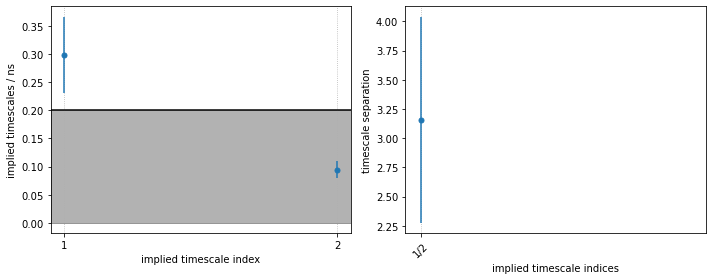

In [ ]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 2
timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

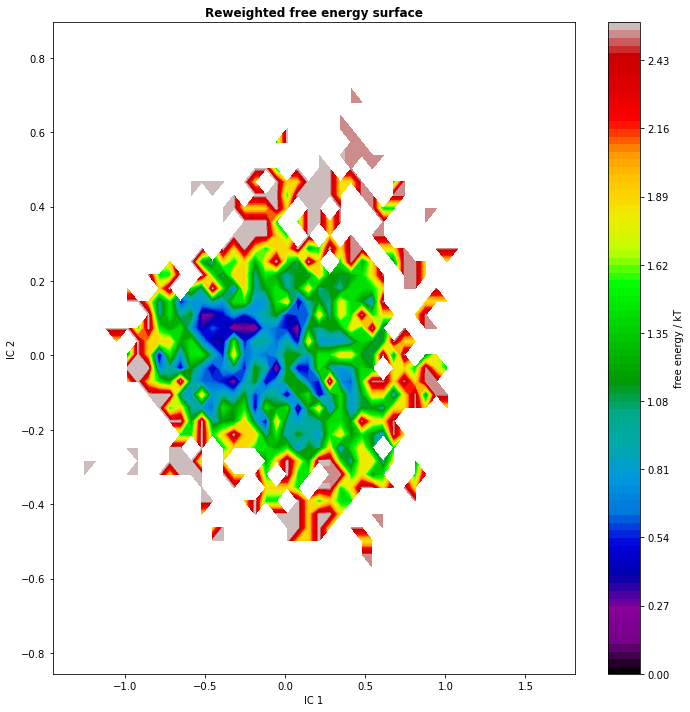

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=ax, cbar=True, nbins=50 ,legacy=False,
    cbar_label='free energy / kT')
ax.set_title('Reweighted free energy surface', fontweight='bold')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

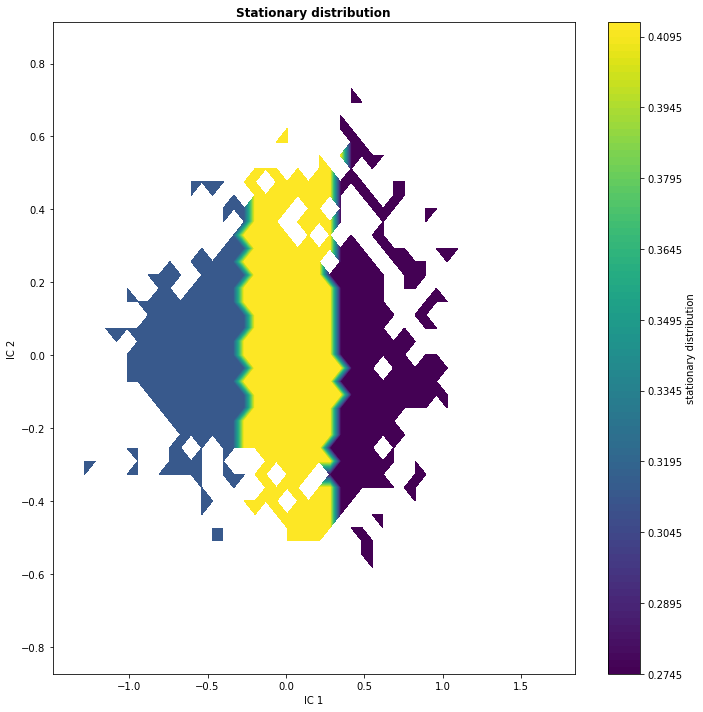

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
     ax=ax, cbar=True, nbins=50, 
    mask=True,
    cbar_label='stationary distribution')
ax.set_title('Stationary distribution', fontweight='bold')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

The first eigenvector is one: True (min=0.9999999999999994, max=1.0000000000000007)


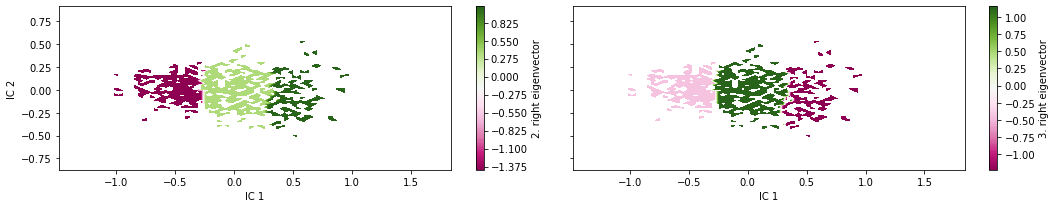

In [ ]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [ ]:
msm.pcca(nstates)

PCCA(P=array([[0.63968, 0.07986, 0.28045],
       [0.0908 , 0.48405, 0.42514],
       [0.21352, 0.28468, 0.5018 ]]),
   m=3)

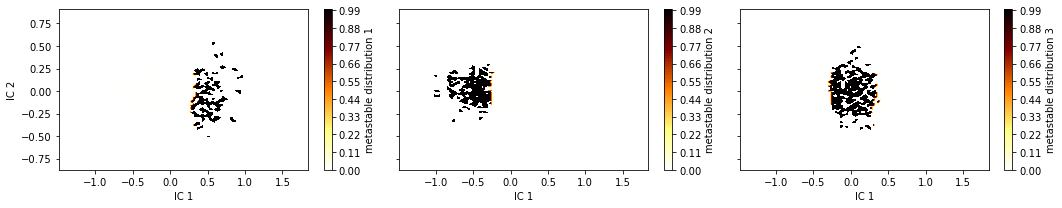

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

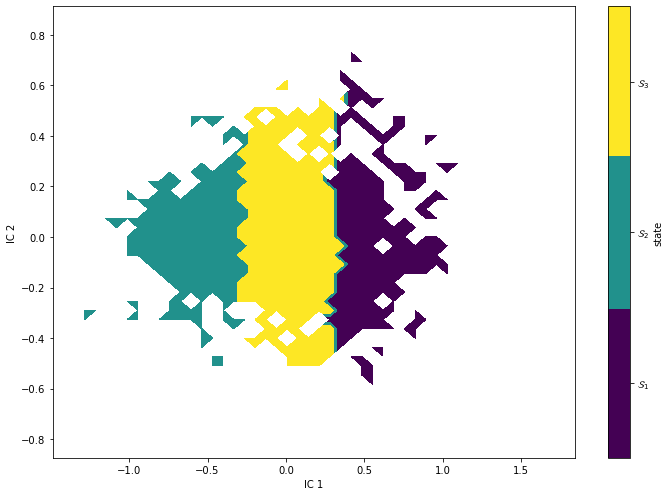

In [ ]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax, nbins=50)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [ ]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 530)
torsions_source = pyemma.coordinates.source(files, features=distances_feat)
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=[r'/home/lbcb/ser333pyemma/metastate_0/pcca{}_530samples.pdb'.format(n + 1)
              for n in range(msm.n_metastable)])

/home/lbcb/anaconda3/lib/python3.8/site-packages/mdtraj/core/trajectory.py:1888: RuntimeWarning: invalid value encountered in less
  if self.unitcell_lengths is not None and np.any(self.unitcell_lengths < 0):
/home/lbcb/anaconda3/lib/python3.8/site-packages/mdtraj/core/trajectory.py:1891: RuntimeWarning: invalid value encountered in less
  if self.unitcell_angles is not None and np.any(self.unitcell_angles < 0):


['/home/lbcb/ser333pyemma/metastate_0/pcca1_530samples.pdb',
 '/home/lbcb/ser333pyemma/metastate_0/pcca2_530samples.pdb',
 '/home/lbcb/ser333pyemma/metastate_0/pcca3_530samples.pdb']

In [ ]:
len(pcca_samples)

359

#metastable_distributions:Probability of metastable states to visit an MSM state by PCCA++
msm.metastable_distributions
#pyemma.coordinates.save_trajs(traj_inp, indexes, prefix='set_', fmt=None, outfiles=None, inmemory=False, stride=1, verbose=False)Saves sequences of frames as multiple trajectories.Extracts a number of specified sequences of time/trajectory indexes from the input loader and saves them in a set of molecular dynamics trajectories. The output filenames are obtained by prefix + str(n) + .fmt, where n counts the output trajectory and extension is either set by the user, or else determined from the input. Example: When the input is in dcd format, and indexes is a list of length 3, the output will by default go to files “set_1.dcd”, “set_2.dcd”, “set_3.dcd”. If you want files to be stored in a specific subfolder, simply specify the relative path in the prefix, e.g. prefix=’~/macrostates/pcca_’

http://www.emma-project.org/latest/api/generated/pyemma.coordinates.save_trajs.html?highlight=pyemma%20coordinates%20save_trajs

sample_by_distributions(distributions, nsample):
    Generates samples according to given probability distributions
    
sample_by_state(nsample[, subset, replace]):
    Generates samples of the connected states.
    http://www.emma-project.org/latest/api/generated/pyemma.msm.BayesianMSM.html

in this cell calcul to all frame ser333 first is OFo

In [ ]:
import pandas as pd 
ser333_disT_data0 = pd.read_csv(r"/home/lbcb/ser333pyemma/allstruturemetric/resulta_ser333_metastate_0.csv")
ser333_disT_data0.head(2)
ser333_disT_data0.columns = ['TM1b-TM10','TM1a-TM6b','TM6a-TM10',
                     'TM1-TM10','R85-D476','F320-Y156','E428-R445',
                     'D436-R60','D345-K66','G258-G263','RMSD']
ser333_disT_data0.head(2000)

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD
0,17.456185,12.177253,19.356543,20.195338,11.374576,12.881320,10.345389,14.464797,15.403446,12.442130,1.489662
1,18.091229,11.076698,20.060005,19.993897,12.089195,13.184383,10.427470,14.850841,15.136074,11.572622,1.304368
2,17.984279,11.795429,19.061337,20.722504,12.341943,12.512882,11.117576,15.684301,15.122478,12.991027,1.325459
3,18.052135,11.143001,19.559749,20.171157,12.094147,13.432736,11.118136,15.439801,15.171091,12.523684,1.221843
4,18.020610,11.263889,19.515982,19.958045,12.370365,14.151929,11.018398,15.046357,15.797802,11.745621,1.216427
...,...,...,...,...,...,...,...,...,...,...,...
1995,17.920421,11.070823,17.544961,20.508071,12.516658,10.825251,10.778607,16.429728,17.480102,13.200892,1.916541
1996,17.559438,10.869551,19.704664,19.896538,11.879609,13.734575,10.881637,13.574257,14.099567,13.571099,1.425461
1997,16.216967,10.177335,19.255126,19.847883,10.306081,14.565470,10.455545,18.031363,18.466317,13.614195,1.584806
1998,17.726400,11.377328,20.128310,19.347597,11.795653,14.603371,10.237401,15.719724,16.529585,12.373278,1.798088


In [ ]:
OFo_TM1b_1=(ser333_disT_data0["TM1b-TM10"]>= 18) & (ser333_disT_data0["TM1b-TM10"]<=19.5)
OFo_TM1a_TM6b_1=(ser333_disT_data0["TM1a-TM6b"]>= 10) & (ser333_disT_data0["TM1a-TM6b"]<=12)
OFo_TM6a_TM10_1=(ser333_disT_data0["TM6a-TM10"]>= 21) & (ser333_disT_data0["TM6a-TM10"]<=22.9) 
OFo_R85_D476_1=(ser333_disT_data0["R85-D476"]>= 10) & (ser333_disT_data0["R85-D476"]<=12) 
OFo_F320_Y156_1=(ser333_disT_data0["F320-Y156"]>= 11) & (ser333_disT_data0["F320-Y156"]<=15) 

OFo_disT_1=ser333_disT_data0[OFo_TM1b_1 & OFo_TM1a_TM6b_1& OFo_TM6a_TM10_1 & OFo_R85_D476_1 & OFo_F320_Y156_1]
serOFo_disT_1=OFo_disT_1[OFo_disT_1.columns[0]].count()
serOFo_disT_1

2

In [ ]:
OFo_disT_1

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD
1082,18.407707,10.891813,21.195202,20.157943,11.764046,14.896199,11.291171,16.375538,16.429559,12.641999,1.595857
1482,18.273295,10.208130,21.542246,20.366331,11.175917,14.663186,10.601637,16.113458,16.219790,13.826697,1.825470


In [ ]:
OFc_TM1b_1=(ser333_disT_data0["TM1b-TM10"]>= 15.4) & (ser333_disT_data0["TM1b-TM10"]<=16.4)
OFc_TM1a_TM6b_1=(ser333_disT_data0["TM1a-TM6b"]>= 10) & (ser333_disT_data0["TM1a-TM6b"]<=12)
OFc_TM6a_TM10_1=(ser333_disT_data0["TM6a-TM10"]>= 18) & (ser333_disT_data0["TM6a-TM10"]<=19) 
OFc_R85_D476_1=(ser333_disT_data0["R85-D476"]<=9) 
OFc_F320_Y156_1=(ser333_disT_data0["F320-Y156"]>=7) & (ser333_disT_data0["F320-Y156"]<=9) 

OFc_disT_1=ser333_disT_data0[OFc_TM1b_1 & OFc_TM1a_TM6b_1& OFc_TM6a_TM10_1 & OFc_R85_D476_1 ]
serOFc_disT_1=OFc_disT_1[OFc_disT_1.columns[0]].count()
serOFc_disT_1

2

In [ ]:
OFc_disT_1

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD
304,16.249546,10.988114,18.697696,19.088271,8.692207,13.128155,10.942631,18.094718,15.897108,15.267543,2.151241
1298,15.682738,11.213631,18.826300,18.625557,8.909523,13.920185,10.503336,14.931021,15.677328,14.349572,1.686673


In [ ]:
holo_TM1b_1=(ser333_disT_data0["TM1b-TM10"]>= 14.1) & (ser333_disT_data0["TM1b-TM10"]<=15.1)
holo_TM1a_TM6b_1=(ser333_disT_data0["TM1a-TM6b"]>= 10) & (ser333_disT_data0["TM1a-TM6b"]<=12)
holo_TM6a_TM10_1=(ser333_disT_data0["TM6a-TM10"]>= 16.4) & (ser333_disT_data0["TM6a-TM10"]<=17.4) 
holo_R85_D476_1=(ser333_disT_data0["R85-D476"]<=9) 
 

holo_disT_1=ser333_disT_data0[holo_TM1b_1 & holo_TM1a_TM6b_1& holo_TM6a_TM10_1 & holo_R85_D476_1 ]
serholo_disT_1=holo_disT_1[holo_disT_1.columns[0]].count()
serholo_disT_1

2

In [ ]:
holo_disT_1

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD
369,15.042049,11.299237,17.195472,18.852563,8.944831,13.102392,10.402672,14.353847,15.846323,12.910099,1.857259
1169,14.951506,11.649983,16.966998,18.408357,8.916231,12.618167,10.582964,14.202124,16.377001,12.278961,1.427801


In [ ]:
IFo_TM1b_1= (ser333_disT_data0["TM1b-TM10"]<=14.1)
IFo_TM1a_TM6b_1=(ser333_disT_data0["TM1a-TM6b"]>= 14) 
IFo_TM6a_TM10_1=(ser333_disT_data0["TM6a-TM10"]<=16.4) 
IFo_D436_R60_1=(ser333_disT_data0["D436-R60"]>= 20) 
IFo_disT_1=ser333_disT_data0[ IFo_TM1a_TM6b_1& IFo_D436_R60_1 ]
serIFo_disT_1=IFo_disT_1[IFo_disT_1.columns[0]].count()
serIFo_disT_1

0

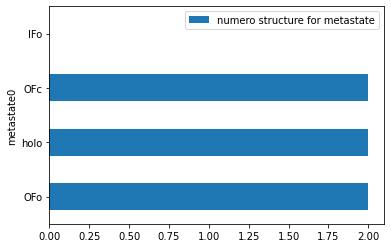

In [ ]:
df1 = pd.DataFrame({'metastate0': ['OFo', 'holo','OFc','IFo'], 'numero structure for metastate': [serOFo_disT_1,serholo_disT_1,serOFc_disT_1,serIFo_disT_1]}) 
ax1 = df1.plot.barh(x='metastate0', y='numero structure for metastate')

M1 metastate

In [ ]:
import pandas as pd 
ser_all_disT_data_M1 = pd.read_csv(r"/home/lbcb/ser333pyemma/metastate_0/M1/resulta_ser333_M1.csv")
ser_all_disT_data_M1.head(2)
ser_all_disT_data_M1.columns = ['TM1b-TM10','TM1a-TM6b','TM6a-TM10',
                     'TM1-TM10','R85-D476','F320-Y156','E428-R445',
                     'D436-R60','D345-K66','G258-G263','RMSD_Ofo','RMSD_Ofc','RMSD_holo']
ser_all_disT_data_M1.head(230)

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD_Ofo,RMSD_Ofc,RMSD_holo
0,16.500068,10.536955,19.074660,19.980439,10.984483,14.465351,10.813770,16.063219,16.905327,13.247665,1.915116,2.446227,1.557554
1,16.340850,10.021984,19.357454,18.771143,10.253422,15.846898,10.924280,15.985511,17.913551,12.659138,1.975488,2.376512,1.694449
2,16.971886,10.730425,19.680224,19.017083,9.825688,15.642958,13.135628,13.639684,17.897915,12.075260,2.432140,3.233543,2.364498
3,17.065511,10.761910,17.843826,18.931795,11.480115,12.944105,11.147581,14.048158,16.430853,12.928011,2.146713,2.269255,1.705897
4,17.253967,10.875833,19.488590,20.555100,11.430223,14.990488,11.279212,16.690216,15.384312,12.553588,1.556329,2.146093,1.729727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,17.668139,9.669816,19.708139,19.603542,11.314474,15.084494,11.716271,14.127992,15.425619,12.249176,2.377081,3.099505,2.063797
226,17.267488,10.570531,19.257030,19.446321,11.322579,12.698444,10.501763,13.722112,17.543113,12.661256,1.781111,2.356972,1.505538
227,16.284735,11.237672,19.452101,21.186965,9.926427,14.471095,10.746050,18.347831,17.766538,15.118027,2.733422,3.218514,2.462210
228,16.786335,11.103064,17.574354,20.334212,12.147347,12.842540,11.248665,16.695791,16.701396,13.175905,1.938132,2.235195,1.889704


In [ ]:
OFo_TM1b_1_1=(ser_all_disT_data_M1["TM1b-TM10"]>= 18) & (ser_all_disT_data_M1["TM1b-TM10"]<=19.5)
OFo_TM1a_TM6b_1_1=(ser_all_disT_data_M1["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M1["TM1a-TM6b"]<=12)
OFo_TM6a_TM10_1_1=(ser_all_disT_data_M1["TM6a-TM10"]>= 21) & (ser_all_disT_data_M1["TM6a-TM10"]<=22.9) 
OFo_R85_D476_1_1=(ser_all_disT_data_M1["R85-D476"]>= 10) & (ser_all_disT_data_M1["R85-D476"]<=12) 
OFo_F320_Y156_1_1=(ser_all_disT_data_M1["F320-Y156"]>= 11) & (ser_all_disT_data_M1["F320-Y156"]<=15) 

OFo_disT_1_1=ser_all_disT_data_M1[OFo_TM1b_1_1 & OFo_TM1a_TM6b_1_1& OFo_TM6a_TM10_1_1 & OFo_R85_D476_1_1 & OFo_F320_Y156_1_1]
serOFo_disT_1_1=OFo_disT_1_1[OFo_disT_1_1.columns[0]].count()
serOFo_disT_1_1

0

In [ ]:
OFc_TM1b_1_1=(ser_all_disT_data_M1["TM1b-TM10"]>= 15.4) & (ser_all_disT_data_M1["TM1b-TM10"]<=16.4)
OFc_TM1a_TM6b_1_1=(ser_all_disT_data_M1["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M1["TM1a-TM6b"]<=12)
OFc_TM6a_TM10_1_1=(ser_all_disT_data_M1["TM6a-TM10"]>= 18) & (ser_all_disT_data_M1["TM6a-TM10"]<=19) 
OFc_R85_D476_1_1=(ser_all_disT_data_M1["R85-D476"]<=9) 
OFc_F320_Y156_1_1=(ser_all_disT_data_M1["F320-Y156"]>=7) & (ser_all_disT_data_M1["F320-Y156"]<=9) 

OFc_disT_1_1=ser_all_disT_data_M1[OFc_TM1b_1_1 & OFc_TM1a_TM6b_1_1& OFc_TM6a_TM10_1_1 & OFc_R85_D476_1_1 ]
serOFc_disT_1_1=OFc_disT_1_1[OFc_disT_1_1.columns[0]].count()
serOFc_disT_1_1

0

In [ ]:
holo_TM1b_1_1=(ser_all_disT_data_M1["TM1b-TM10"]>= 14.1) & (ser_all_disT_data_M1["TM1b-TM10"]<=15.1)
holo_TM1a_TM6b_1_1=(ser_all_disT_data_M1["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M1["TM1a-TM6b"]<=12)
holo_TM6a_TM10_1_1=(ser_all_disT_data_M1["TM6a-TM10"]>= 16.4) & (ser_all_disT_data_M1["TM6a-TM10"]<=17.4) 
holo_R85_D476_1_1=(ser_all_disT_data_M1["R85-D476"]<=9) 
 

holo_disT_1_1=ser_all_disT_data_M1[holo_TM1b_1_1 & holo_TM1a_TM6b_1_1& holo_TM6a_TM10_1_1 & holo_R85_D476_1_1 ]
serholo_disT_1_1=holo_disT_1_1[holo_disT_1_1.columns[0]].count()
serholo_disT_1_1

0

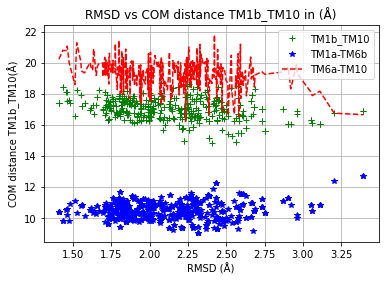

In [ ]:
serall_data1_M1=ser_all_disT_data_M1.sort_values(by='RMSD_Ofo', ascending=True, na_position='first')

s1_1=serall_data1_M1["TM1b-TM10"]
t1_1= serall_data1_M1["RMSD_Ofo"]
s2_1=serall_data1_M1["TM1a-TM6b"]
t2_1=serall_data1_M1["RMSD_Ofo"]
s3_1=serall_data1_M1["TM6a-TM10"]
t3_1=serall_data1_M1["RMSD_Ofo"]
fig, ax = plt.subplots()
ax.plot(t1_1, s1_1,"+", color='green',label='TM1b_TM10')
ax.plot(t1_1, s2_1,"*",color='blue', label="TM1a-TM6b")
ax.plot(t1_1, s3_1,"--",color='red', label="TM6a-TM10" )
ax.legend()
ax.set(xlabel='RMSD (Å)', ylabel='COM distance TM1b_TM10(Å)',
       title='RMSD vs COM distance TM1b_TM10 in (Å)')
ax.grid()

#fig.savefig("test.png")
plt.show()

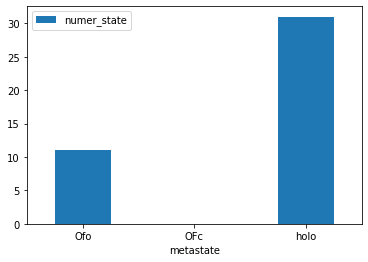

In [ ]:
figrmsdOFo_M1 =len(ser_all_disT_data_M1[ser_all_disT_data_M1["RMSD_Ofo"]<=1.5])
figrmsdOFc_M1 =len(ser_all_disT_data_M1[ser_all_disT_data_M1["RMSD_Ofc"]<=1.5])
figrmsdholo_M1 =len(ser_all_disT_data_M1[ser_all_disT_data_M1["RMSD_holo"]<=1.5])

df_M1 = pd.DataFrame({'metastate':['Ofo', 'OFc', 'holo'], 'numer_state':[figrmsdOFo_M1,figrmsdOFc_M1,figrmsdholo_M1]})
ax_M1 = df_M1.plot.bar(x='metastate', y='numer_state', rot=0)

M2 metastate

In [ ]:
import pandas as pd 
ser_all_disT_data_M2 = pd.read_csv(r"/home/lbcb/ser333pyemma/metastate_0/M2/resulta_ser333_M2.csv")
ser_all_disT_data_M2.head(2)
ser_all_disT_data_M2.columns = ['TM1b-TM10','TM1a-TM6b','TM6a-TM10',
                     'TM1-TM10','R85-D476','F320-Y156','E428-R445',
                     'D436-R60','D345-K66','G258-G263','RMSD_Ofo','RMSD_Ofc','RMSD_holo']
ser_all_disT_data_M2.head(230)

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD_Ofo,RMSD_Ofc,RMSD_holo
0,17.955206,11.250107,19.351950,20.186837,12.112724,13.429322,11.382309,14.901329,16.237716,13.194371,1.357928,2.111334,1.596464
1,16.462379,11.408213,18.940271,20.004296,10.023606,12.943034,10.796699,16.320125,16.279756,12.126454,1.560159,1.961326,1.545447
2,16.925830,10.354331,18.821139,19.555730,10.742870,13.672095,10.539025,15.220259,15.709863,11.494573,1.651476,2.317216,1.473619
3,16.406413,10.857409,17.008047,19.380014,10.959264,13.384709,10.438993,12.960992,18.154901,12.921864,3.103323,2.554460,2.322033
4,18.201122,10.593592,19.108097,21.144160,13.241669,12.121657,10.859724,16.142807,15.479787,12.268362,1.636165,2.143531,1.695437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,17.846612,11.859831,19.921972,20.066732,11.692324,13.303903,10.377056,14.427716,15.664452,10.871335,1.359311,2.149833,1.456993
226,17.954367,11.155945,19.500158,20.197676,12.613058,13.201014,10.961063,14.848828,15.316410,13.484618,1.441224,1.935073,1.533461
227,16.894789,11.097541,20.227338,18.924294,11.939742,14.538836,10.992422,17.246265,13.148504,13.812820,1.874137,2.046903,2.665608
228,17.889294,11.341755,18.965892,19.604785,11.734916,13.105771,10.581837,13.800461,15.215881,12.298667,1.609812,2.089454,1.365069


In [ ]:
OFo_TM1b_1_2=(ser_all_disT_data_M2["TM1b-TM10"]>= 18) & (ser_all_disT_data_M2["TM1b-TM10"]<=19.5)
OFo_TM1a_TM6b_1_2=(ser_all_disT_data_M2["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M2["TM1a-TM6b"]<=12)
OFo_TM6a_TM10_1_2=(ser_all_disT_data_M2["TM6a-TM10"]>= 21) & (ser_all_disT_data_M2["TM6a-TM10"]<=22.9) 
OFo_R85_D476_1_2=(ser_all_disT_data_M2["R85-D476"]>= 10) & (ser_all_disT_data_M2["R85-D476"]<=12) 
OFo_F320_Y156_1_2=(ser_all_disT_data_M2["F320-Y156"]>= 11) & (ser_all_disT_data_M2["F320-Y156"]<=15) 

OFo_disT_1_2=ser_all_disT_data_M2[OFo_TM1b_1_2 & OFo_TM1a_TM6b_1_2& OFo_TM6a_TM10_1_2 & OFo_R85_D476_1_2 & OFo_F320_Y156_1_2]
serOFo_disT_1_2=OFo_disT_1_2[OFo_disT_1_2.columns[0]].count()
serOFo_disT_1_2

0

In [ ]:
OFc_TM1b_1_2=(ser_all_disT_data_M2["TM1b-TM10"]>= 15.4) & (ser_all_disT_data_M2["TM1b-TM10"]<=16.4)
OFc_TM1a_TM6b_1_2=(ser_all_disT_data_M2["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M2["TM1a-TM6b"]<=12)
OFc_TM6a_TM10_1_2=(ser_all_disT_data_M2["TM6a-TM10"]>= 18) & (ser_all_disT_data_M2["TM6a-TM10"]<=19) 
OFc_R85_D476_1_2=(ser_all_disT_data_M2["R85-D476"]<=9) 
OFc_F320_Y156_1_2=(ser_all_disT_data_M2["F320-Y156"]>=7) & (ser_all_disT_data_M2["F320-Y156"]<=9) 

OFc_disT_1_2=ser_all_disT_data_M2[OFc_TM1b_1_2 & OFc_TM1a_TM6b_1_2& OFc_TM6a_TM10_1_2 & OFc_R85_D476_1_2 ]
serOFc_disT_1_2=OFc_disT_1_2[OFc_disT_1_2.columns[0]].count()
serOFc_disT_1_2

0

In [ ]:
holo_TM1b_1_2=(ser_all_disT_data_M2["TM1b-TM10"]>= 14.1) & (ser_all_disT_data_M2["TM1b-TM10"]<=15.1)
holo_TM1a_TM6b_1_2=(ser_all_disT_data_M2["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M2["TM1a-TM6b"]<=12)
holo_TM6a_TM10_1_2=(ser_all_disT_data_M2["TM6a-TM10"]>= 16.4) & (ser_all_disT_data_M2["TM6a-TM10"]<=17.4) 
holo_R85_D476_1_2=(ser_all_disT_data_M2["R85-D476"]<=9) 
 

holo_disT_1_2=ser_all_disT_data_M2[holo_TM1b_1_2 & holo_TM1a_TM6b_1_2& holo_TM6a_TM10_1_2 & holo_R85_D476_1_2 ]
serholo_disT_1_2=holo_disT_1_2[holo_disT_1_2.columns[0]].count()
serholo_disT_1_2

0

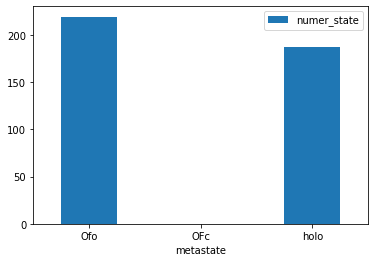

In [ ]:
figrmsdOFo_M2 =len(ser_all_disT_data_M2[ser_all_disT_data_M2["RMSD_Ofo"]<=1.5])
figrmsdOFc_M2 =len(ser_all_disT_data_M2[ser_all_disT_data_M2["RMSD_Ofc"]<=1.5])
figrmsdholo_M2 =len(ser_all_disT_data_M2[ser_all_disT_data_M2["RMSD_holo"]<=1.5])

df_M2 = pd.DataFrame({'metastate':['Ofo', 'OFc', 'holo'], 'numer_state':[figrmsdOFo_M2,figrmsdOFc_M2,figrmsdholo_M2]})
ax_M2 = df_M2.plot.bar(x='metastate', y='numer_state', rot=0)

M3 metastate

In [ ]:
import pandas as pd 
ser_all_disT_data_M3 = pd.read_csv(r"/home/lbcb/ser333pyemma/metastate_0/M3/resulta_ser333_M3.csv")
ser_all_disT_data_M3.head(2)
ser_all_disT_data_M3.columns = ['TM1b-TM10','TM1a-TM6b','TM6a-TM10',
                     'TM1-TM10','R85-D476','F320-Y156','E428-R445',
                     'D436-R60','D345-K66','G258-G263','RMSD_Ofo','RMSD_Ofc','RMSD_holo']
ser_all_disT_data_M3.head(230)

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD_Ofo,RMSD_Ofc,RMSD_holo
0,17.458534,9.924252,19.526887,20.235786,11.184848,13.379596,11.221975,15.670342,17.422026,13.156046,2.435188,2.823353,1.897851
1,17.600200,11.432696,17.821002,20.102364,12.943186,10.099853,10.638940,15.627652,12.186467,15.439006,2.335588,2.114104,2.204578
2,16.645260,10.451873,18.186533,19.406252,11.056799,12.248777,10.519683,14.333859,16.569291,11.603782,1.860155,2.301305,1.155045
3,16.659945,10.911365,18.940895,19.714826,10.900268,13.840679,10.128916,17.786470,16.022497,13.012171,1.723962,2.318296,1.763705
4,16.725655,11.205180,18.671670,19.516740,11.831005,12.214101,10.748272,13.534842,16.537073,12.264059,2.067308,2.525509,1.376858
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,17.267823,11.120545,19.125658,20.783493,11.464967,13.818691,10.929557,17.124489,16.999373,13.332459,1.892138,2.222514,1.739555
226,17.465578,10.590005,18.914042,21.369975,13.081451,12.472836,10.688744,13.241950,16.399570,11.544859,2.008967,2.077538,1.796832
227,17.436950,10.645622,19.280162,19.404410,11.419778,14.364478,10.720805,12.904451,15.902686,13.139244,1.725310,2.133974,1.433986
228,17.795009,11.289828,19.518435,20.316356,11.906890,14.212820,10.831473,15.980364,16.529312,11.692053,1.385444,2.098079,1.620920


In [ ]:
OFo_TM1b_1_3=(ser_all_disT_data_M3["TM1b-TM10"]>= 18) & (ser_all_disT_data_M3["TM1b-TM10"]<=19.5)
OFo_TM1a_TM6b_1_3=(ser_all_disT_data_M3["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M3["TM1a-TM6b"]<=12)
OFo_TM6a_TM10_1_3=(ser_all_disT_data_M3["TM6a-TM10"]>= 21) & (ser_all_disT_data_M3["TM6a-TM10"]<=22.9) 
OFo_R85_D476_1_3=(ser_all_disT_data_M3["R85-D476"]>= 10) & (ser_all_disT_data_M3["R85-D476"]<=12) 
OFo_F320_Y156_1_3=(ser_all_disT_data_M3["F320-Y156"]>= 11) & (ser_all_disT_data_M3["F320-Y156"]<=15) 

OFo_disT_1_3=ser_all_disT_data_M3[OFo_TM1b_1_3 & OFo_TM1a_TM6b_1_3& OFo_TM6a_TM10_1_3 & OFo_R85_D476_1_3 & OFo_F320_Y156_1_3]
serOFo_disT_1_3=OFo_disT_1_3[OFo_disT_1_3.columns[0]].count()
serOFo_disT_1_3

1

In [ ]:
OFc_TM1b_1_3=(ser_all_disT_data_M3["TM1b-TM10"]>= 15.4) & (ser_all_disT_data_M3["TM1b-TM10"]<=16.4)
OFc_TM1a_TM6b_1_3=(ser_all_disT_data_M3["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M3["TM1a-TM6b"]<=12)
OFc_TM6a_TM10_1_3=(ser_all_disT_data_M3["TM6a-TM10"]>= 18) & (ser_all_disT_data_M3["TM6a-TM10"]<=19) 
OFc_R85_D476_1_3=(ser_all_disT_data_M3["R85-D476"]<=9) 
OFc_F320_Y156_1_3=(ser_all_disT_data_M3["F320-Y156"]>=7) & (ser_all_disT_data_M3["F320-Y156"]<=9) 

OFc_disT_1_3=ser_all_disT_data_M3[OFc_TM1b_1_3 & OFc_TM1a_TM6b_1_3& OFc_TM6a_TM10_1_3 & OFc_R85_D476_1_3 ]
serOFc_disT_1_3=OFc_disT_1_3[OFc_disT_1_3.columns[0]].count()
serOFc_disT_1_3

1

In [ ]:
holo_TM1b_1_3=(ser_all_disT_data_M3["TM1b-TM10"]>= 14.1) & (ser_all_disT_data_M3["TM1b-TM10"]<=15.1)
holo_TM1a_TM6b_1_3=(ser_all_disT_data_M3["TM1a-TM6b"]>= 10) & (ser_all_disT_data_M3["TM1a-TM6b"]<=12)
holo_TM6a_TM10_1_3=(ser_all_disT_data_M3["TM6a-TM10"]>= 16.4) & (ser_all_disT_data_M3["TM6a-TM10"]<=17.4) 
holo_R85_D476_1_3=(ser_all_disT_data_M3["R85-D476"]<=9) 
 

holo_disT_1_3=ser_all_disT_data_M3[holo_TM1b_1_3 & holo_TM1a_TM6b_1_3& holo_TM6a_TM10_1_3 & holo_R85_D476_1_3 ]
serholo_disT_1_3=holo_disT_1_3[holo_disT_1_3.columns[0]].count()
serholo_disT_1_3

0

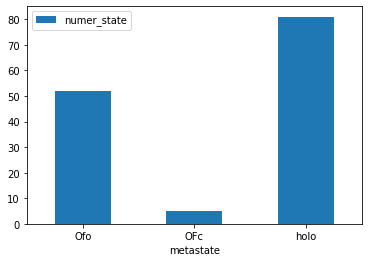

In [ ]:
figrmsdOFo_M3 =len(ser_all_disT_data_M3[ser_all_disT_data_M3["RMSD_Ofo"]<=1.5])
figrmsdOFc_M3 =len(ser_all_disT_data_M3[ser_all_disT_data_M3["RMSD_Ofc"]<=1.5])
figrmsdholo_M3 =len(ser_all_disT_data_M3[ser_all_disT_data_M3["RMSD_holo"]<=1.5])

df_M3 = pd.DataFrame({'metastate':['Ofo', 'OFc', 'holo'], 'numer_state':[figrmsdOFo_M3,figrmsdOFc_M3,figrmsdholo_M3]})
ax_M3 = df_M3.plot.bar(x='metastate', y='numer_state', rot=0)

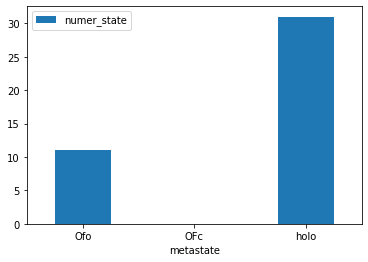

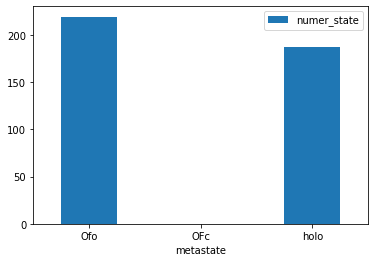

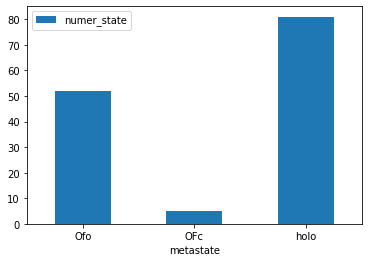

In [ ]:
df_M1 = pd.DataFrame({'metastate':['Ofo', 'OFc', 'holo'], 'numer_state':[figrmsdOFo_M1,figrmsdOFc_M1,figrmsdholo_M1]})
ax_M1 = df_M1.plot.bar(x='metastate', y='numer_state', rot=0)
df_M2 = pd.DataFrame({'metastate':['Ofo', 'OFc', 'holo'], 'numer_state':[figrmsdOFo_M2,figrmsdOFc_M2,figrmsdholo_M2]})
ax_M2 = df_M2.plot.bar(x='metastate', y='numer_state', rot=0)
df_M3 = pd.DataFrame({'metastate':['Ofo', 'OFc', 'holo'], 'numer_state':[figrmsdOFo_M3,figrmsdOFc_M3,figrmsdholo_M3]})
ax_M3 = df_M3.plot.bar(x='metastate', y='numer_state', rot=0)

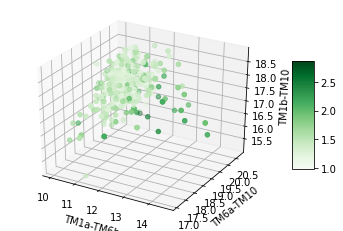

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')


# Data for a three-dimensional line
#zline = rmsd_data4["TM6a-TM10"]
#xline = rmsd_data4["TM1b_TM10"]
#yline = rmsd_data4["TM1a-TM6b"]
#ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata1 = ser333_disT_data1["TM1b-TM10"]
xdata1 = ser333_disT_data1["TM1a-TM6b"]
ydata1 = ser333_disT_data1["TM6a-TM10"]
wdata1 = ser333_disT_data1["RMSD"]
surf1=ax.scatter3D(xdata1, ydata1, zdata1, c=wdata1, cmap='Greens');
fig.colorbar(surf1, shrink=0.5, aspect=5)
ax.set_xlabel('TM1a-TM6b')
ax.set_ylabel('TM6a-TM10')
ax.set_zlabel('TM1b-TM10')
plt.show()

In [ ]:
ser333_data1_1=ser333_disT_data1.sort_values(by='RMSD', ascending=True, na_position='first')
ser333_data1_1.head(580)

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,RMSD
521,16.984014,11.197982,18.996764,19.478262,11.513732,13.786186,10.995884,13.349077,16.497417,11.410136,0.974544
88,17.479514,10.779448,19.516932,20.049938,11.136807,13.736661,10.769774,13.576852,15.936618,11.711591,1.026931
166,17.889557,11.583739,19.172227,20.226456,11.945819,12.663610,9.980671,13.855871,15.030559,11.994895,1.073616
129,17.110728,11.400800,19.037418,19.545223,11.104177,12.716455,10.769584,14.748946,16.288242,12.095674,1.079110
230,17.417761,11.421452,18.977471,19.953229,11.330907,13.022302,10.537577,14.559971,15.096950,12.363194,1.079225
...,...,...,...,...,...,...,...,...,...,...,...
345,17.755873,12.502414,19.407199,21.054143,11.344828,12.660090,10.436774,18.683731,17.416349,13.233669,2.247479
511,16.894789,11.097541,20.227338,18.924294,11.939742,14.538836,10.992422,17.246265,13.148504,13.812820,2.270304
411,16.738079,13.257800,18.342695,19.329122,11.063036,13.920194,10.429065,15.762340,18.332306,13.191831,2.341537
184,17.212505,12.313791,19.658191,20.068836,10.661743,14.514582,9.810284,17.993670,17.008473,13.168883,2.383625


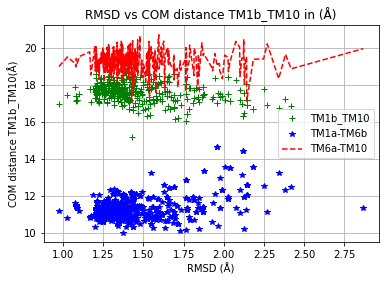

In [ ]:
s1_1=ser333_data1_1["TM1b-TM10"]
t1_1= ser333_data1_1["RMSD"]
s2_1=ser333_data1_1["TM1a-TM6b"]
t2_1=ser333_data1_1["RMSD"]
s3_1=ser333_data1_1["TM6a-TM10"]
t3_1=ser333_data1_1["RMSD"]
fig, ax = plt.subplots()
ax.plot(t1_1, s1_1,"+", color='green',label='TM1b_TM10')
ax.plot(t1_1, s2_1,"*",color='blue', label="TM1a-TM6b")
ax.plot(t1_1, s3_1,"--",color='red', label="TM6a-TM10" )
ax.legend()
ax.set(xlabel='RMSD (Å)', ylabel='COM distance TM1b_TM10(Å)',
       title='RMSD vs COM distance TM1b_TM10 in (Å)')
ax.grid()

#fig.savefig("test.png")
plt.show()


In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px


In [ ]:
fig1 = px.scatter(ser333_data1_1, x="RMSD", y="TM1b-TM10", trendline="ols")
fig1.show()

In [ ]:
fig2 = px.scatter(ser333_data1_1, x="RMSD", y="TM1a-TM6b", trendline="ols")
fig2.show()

In [ ]:
fig3 = px.scatter(ser333_data1, x="RMSD", y="TM6a-TM10", trendline="ols")
fig3.show()

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
app = dash.Dash(__name__)
fig = px.scatter_3d(ser333_data1, 
        x='TM1b-TM10', y='TM1a-TM6b', z='TM6a-TM10',
        color="RMSD")

fig.show()

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
app = dash.Dash(__name__)
fig = px.scatter_3d(ser333_disT_data1, 
        x='TM1b-TM10', y='TM1a-TM6b', z='TM6a-TM10',
        color="OFc_RMSD")

fig.show()

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
app = dash.Dash(__name__)
fig = px.scatter_3d(ser333_disT_data1, 
        x='TM1b-TM10', y='TM1a-TM6b', z='TM6a-TM10',
        color="holo_RMSD")

fig.show()

In [ ]:
import pandas as pd 
ser333_M2 = pd.read_csv(r"/home/lbcb/ser333pyemma/metaestado2/resulta_ser333_metataste_2_2.csv")
ser333_M2.head(2)
ser333_M2.columns = ['TM1b-TM10','TM1a-TM6b','TM6a-TM10',
                     'TM1-TM10','R85-D476','F320-Y156','E428-R445',
                     'D436-R60','D345-K66','G258-G263','OFo_RMSD','OFc_RMSD','holo_RMSD' ]
ser333_M2.head(613)



,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,OFo_RMSD,OFc_RMSD,holo_RMSD
0,17.803641,10.106003,18.956128,18.855583,11.860099,13.699046,10.409377,11.957451,17.589588,14.557025,1.927528,2.886559,2.031732
1,17.765507,12.261494,18.925970,21.233758,13.449051,11.870239,10.824672,17.924369,17.030172,14.277472,2.135215,2.834831,2.008799
2,16.934680,10.197073,19.854754,20.976006,10.664516,15.821156,10.283201,20.278119,17.840780,13.743975,1.892964,2.675709,2.024519
3,17.648717,10.943862,18.811510,21.196375,12.917135,13.273372,10.899580,15.814648,16.084361,12.650955,2.101044,2.430358,2.180070
4,16.805285,9.868138,19.198449,19.427465,10.580323,13.512550,10.489965,14.071068,15.024464,13.406883,1.525333,2.133535,1.375768
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,16.848842,10.757843,18.036272,19.849410,11.090466,13.915182,10.820122,16.560764,16.246942,12.883244,1.813328,2.173852,1.831848
608,16.756330,10.955605,19.459673,20.787761,11.298112,15.366690,9.751153,16.149905,14.970308,14.323935,1.989344,1.940359,1.892999
609,18.121933,10.368997,18.837860,20.539407,13.064193,14.580678,10.538788,14.550802,16.571035,12.607938,1.942097,2.439373,1.848049
610,18.183012,10.593656,19.758733,21.667961,12.710819,13.414537,10.564217,17.718700,17.150637,14.122307,1.688325,2.398967,1.687391


In [ ]:
OFo_TM1b_1_2=(ser333_M2["TM1b-TM10"]>= 18) & (ser333_M2["TM1b-TM10"]<=19.5)
OFo_TM1a_TM6b_1_2=(ser333_M2["TM1a-TM6b"]>= 10) & (ser333_M2["TM1a-TM6b"]<=12)
OFo_TM6a_TM10_1_2=(ser333_M2["TM6a-TM10"]>= 21) & (ser333_M2["TM6a-TM10"]<=22.9) 
OFo_R85_D476_1_2=(ser333_M2["R85-D476"]>= 10) & (ser333_M2["R85-D476"]<=12) 
OFo_F320_Y156_1_2=(ser333_M2["F320-Y156"]>= 11) & (ser333_M2["F320-Y156"]<=15) 

OFo_disT_1_2=ser333_M2[OFo_TM1b_1_2 & OFo_TM1a_TM6b_1_2& OFo_TM6a_TM10_1_2 & OFo_R85_D476_1_2 & OFo_F320_Y156_1_2]
serOFo_disT_1_2=OFo_disT_1_2[OFo_disT_1_2.columns[0]].count()
serOFo_disT_1_2

0

In [ ]:
OFc_TM1b_1_2=(ser333_M2["TM1b-TM10"]>= 15.4) & (ser333_M2["TM1b-TM10"]<=16.4)
OFc_TM1a_TM6b_1_2=(ser333_M2["TM1a-TM6b"]>= 10) & (ser333_M2["TM1a-TM6b"]<=12)
OFc_TM6a_TM10_1_2=(ser333_M2["TM6a-TM10"]>= 18) & (ser333_M2["TM6a-TM10"]<=19) 
OFc_R85_D476_1_2=(ser333_M2["R85-D476"]<=9) 
OFc_F320_Y156_1_2=(ser333_M2["F320-Y156"]>=7) & (ser333_M2["F320-Y156"]<=9) 

OFc_disT_1_2=ser333_M2[OFc_TM1b_1_2 & OFc_TM1a_TM6b_1_2& OFc_TM6a_TM10_1_2 & OFc_R85_D476_1_2 ]
serOFc_disT_1_2=OFc_disT_1_2[OFc_disT_1_2.columns[0]].count()
serOFc_disT_1_2

0

In [ ]:
holo_TM1b_1_2=(ser333_M2["TM1b-TM10"]>= 14.1) & (ser333_M2["TM1b-TM10"]<=15.1)
holo_TM1a_TM6b_1_2=(ser333_M2["TM1a-TM6b"]>= 10) & (ser333_M2["TM1a-TM6b"]<=12)
holo_TM6a_TM10_1_2=(ser333_M2["TM6a-TM10"]>= 16.4) & (ser333_M2["TM6a-TM10"]<=17.4) 
holo_R85_D476_1_2=(ser333_M2["R85-D476"]<=9) 
 

holo_disT_1_2=ser333_M2[holo_TM1b_1_2 & holo_TM1a_TM6b_1_2& holo_TM6a_TM10_1_2 & holo_R85_D476_1_2 ]
serholo_disT_1_2=holo_disT_1_2[holo_disT_1_2.columns[0]].count()
serholo_disT_1_2

0

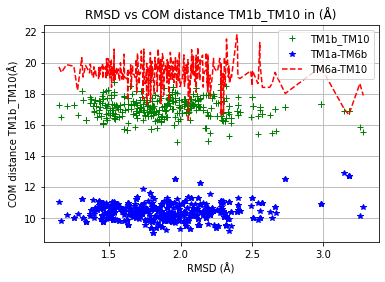

In [ ]:
ser333_M2_1=ser333_M2.sort_values(by='OFo_RMSD', ascending=True, na_position='first')

s1_2=ser333_M2_1["TM1b-TM10"]
t1_2= ser333_M2_1["OFo_RMSD"]
s2_2=ser333_M2_1["TM1a-TM6b"]
t2_2=ser333_M2_1["OFo_RMSD"]
s3_2=ser333_M2_1["TM6a-TM10"]
t3_2=ser333_M2_1["OFo_RMSD"]
fig, ax = plt.subplots()
ax.plot(t1_2, s1_2,"+", color='green',label='TM1b_TM10')
ax.plot(t1_2, s2_2,"*",color='blue', label="TM1a-TM6b")
ax.plot(t1_2, s3_2,"--",color='red', label="TM6a-TM10" )
ax.legend()
ax.set(xlabel='RMSD (Å)', ylabel='COM distance TM1b_TM10(Å)',
       title='RMSD vs COM distance TM1b_TM10 in (Å)')
ax.grid()

#fig.savefig("test.png")
plt.show()


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
app = dash.Dash(__name__)
fig = px.scatter_3d(ser333_M2_1, 
        x='TM1b-TM10', y='TM1a-TM6b', z='TM6a-TM10',
        color="OFo_RMSD")

fig.show()

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
app = dash.Dash(__name__)
fig = px.scatter_3d(ser333_M2_1, 
        x='TM1b-TM10', y='TM1a-TM6b', z='TM6a-TM10',
        color="OFc_RMSD")

fig.show()

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
app = dash.Dash(__name__)
fig = px.scatter_3d(ser333_M2_1, 
        x='TM1b-TM10', y='TM1a-TM6b', z='TM6a-TM10',
        color="holo_RMSD")

fig.show()

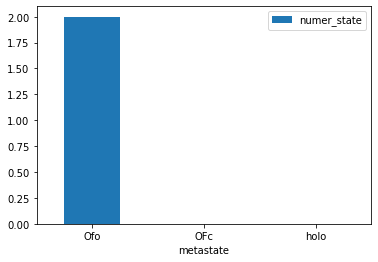

In [ ]:
M2figrmsdOFo =len(ser333_M2_1[ser333_M2_1["OFo_RMSD"]<=1.2])
M2figrmsdOFc =len(ser333_M2_1[ser333_M2_1["OFc_RMSD"]<=1.2])
M2figrmsdholo =len(ser333_M2_1[ser333_M2_1["holo_RMSD"]<=1.2])

dfM2 = pd.DataFrame({'metastate':['Ofo', 'OFc', 'holo'], 'numer_state':[M2figrmsdOFo,M2figrmsdOFc,M2figrmsdholo]})
axM2 = dfM2.plot.bar(x='metastate', y='numer_state', rot=0)

In [ ]:
import pandas as pd 
ser333_M3 = pd.read_csv(r"/home/lbcb/ser333pyemma/metaestado3/resulta_ser333_metastate_3.csv")
ser333_M3.head(2)
ser333_M3.columns = ['TM1b-TM10','TM1a-TM6b','TM6a-TM10',
                     'TM1-TM10','R85-D476','F320-Y156','E428-R445',
                     'D436-R60','D345-K66','G258-G263','OFo_RMSD','OFc_RMSD','holo_RMSD' ]
ser333_M3.head(359)

,TM1b-TM10,TM1a-TM6b,TM6a-TM10,TM1-TM10,R85-D476,F320-Y156,E428-R445,D436-R60,D345-K66,G258-G263,OFo_RMSD,OFc_RMSD,holo_RMSD
0,16.899147,10.442944,19.740464,19.646733,9.534890,14.965532,10.436946,14.871892,15.884145,13.182865,1.623317,2.282472,1.758972
1,16.270718,10.442168,18.815894,18.826606,10.860794,13.376972,10.641267,12.937174,14.609313,13.915123,1.240459,2.148851,1.300150
2,17.584082,10.092066,19.823642,19.284084,11.534043,14.750050,10.105693,12.679979,17.359398,12.478006,1.337827,2.215392,1.574491
3,16.798823,10.717088,19.442095,19.017324,9.983136,13.711231,10.446485,13.376288,15.025986,13.206857,1.026339,2.059469,1.415797
4,17.001375,11.038745,18.695874,19.360441,11.216650,13.780218,10.546831,14.640705,14.284515,11.468897,2.314812,2.335299,2.460002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,16.425483,10.912492,17.861331,19.360539,11.678460,12.837413,11.067202,13.099942,14.984337,13.188801,1.730407,2.479697,1.864839
355,16.598857,9.890403,19.214132,20.227995,11.066230,14.162223,11.426665,13.140672,15.421163,14.671747,1.892662,2.903935,1.844166
356,16.856185,10.162693,19.792142,19.594251,11.052231,14.347878,11.374234,15.115883,15.504040,14.382965,1.403933,2.012288,1.691295
357,15.273920,9.920519,17.743925,19.554977,10.500939,13.541687,10.386960,14.081124,16.359364,13.948936,1.788787,2.262302,1.537592


In [ ]:
OFo_TM1b_1_3=(ser333_M3["TM1b-TM10"]>= 18) & (ser333_M3["TM1b-TM10"]<=19.5)
OFo_TM1a_TM6b_1_3=(ser333_M3["TM1a-TM6b"]>= 10) & (ser333_M3["TM1a-TM6b"]<=12)
OFo_TM6a_TM10_1_3=(ser333_M3["TM6a-TM10"]>= 21) & (ser333_M3["TM6a-TM10"]<=22.9) 
OFo_R85_D476_1_3=(ser333_M3["R85-D476"]>= 10) & (ser333_M3["R85-D476"]<=12) 
OFo_F320_Y156_1_3=(ser333_M3["F320-Y156"]>= 11) & (ser333_M3["F320-Y156"]<=15) 

OFo_disT_1_3=ser333_M3[OFo_TM1b_1_3 & OFo_TM1a_TM6b_1_3& OFo_TM6a_TM10_1_3 & OFo_R85_D476_1_3 & OFo_F320_Y156_1_3]
serOFo_disT_1_3=OFo_disT_1_3[OFo_disT_1_3.columns[0]].count()
serOFo_disT_1_3

2

In [ ]:
OFc_TM1b_1_3=(ser333_M3["TM1b-TM10"]>= 15.4) & (ser333_M3["TM1b-TM10"]<=16.4)
OFc_TM1a_TM6b_1_3=(ser333_M3["TM1a-TM6b"]>= 10) & (ser333_M3["TM1a-TM6b"]<=12)
OFc_TM6a_TM10_1_3=(ser333_M3["TM6a-TM10"]>= 18) & (ser333_M3["TM6a-TM10"]<=19) 
OFc_R85_D476_1_3=(ser333_M3["R85-D476"]<=9) 
OFc_F320_Y156_1_3=(ser333_M3["F320-Y156"]>=7) & (ser333_M3["F320-Y156"]<=9) 

OFc_disT_1_3=ser333_M3[OFc_TM1b_1_3 & OFc_TM1a_TM6b_1_3& OFc_TM6a_TM10_1_3 & OFc_R85_D476_1_3 ]
serOFc_disT_1_3=OFc_disT_1_3[OFc_disT_1_3.columns[0]].count()
serOFc_disT_1_3

3

In [ ]:
holo_TM1b_1_3=(ser333_M3["TM1b-TM10"]>= 14.1) & (ser333_M3["TM1b-TM10"]<=15.1)
holo_TM1a_TM6b_1_3=(ser333_M3["TM1a-TM6b"]>= 10) & (ser333_M3["TM1a-TM6b"]<=12)
holo_TM6a_TM10_1_3=(ser333_M3["TM6a-TM10"]>= 16.4) & (ser333_M3["TM6a-TM10"]<=17.4) 
holo_R85_D476_1_3=(ser333_M3["R85-D476"]<=9) 
 

holo_disT_1_3=ser333_M3[holo_TM1b_1_3 & holo_TM1a_TM6b_1_3& holo_TM6a_TM10_1_3 & holo_R85_D476_1_3 ]
serholo_disT_1_3=holo_disT_1_3[holo_disT_1_3.columns[0]].count()
serholo_disT_1_3

2

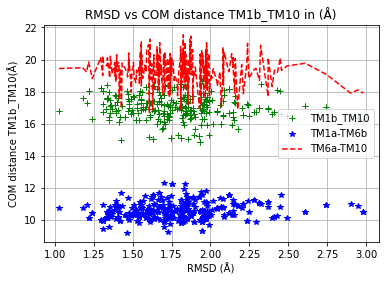

In [ ]:
ser333_M3_1=ser333_M3.sort_values(by='OFo_RMSD', ascending=True, na_position='first')

s1_3=ser333_M3_1["TM1b-TM10"]
t1_3= ser333_M3_1["OFo_RMSD"]
s2_3=ser333_M3_1["TM1a-TM6b"]
t2_3=ser333_M3_1["OFo_RMSD"]
s3_3=ser333_M3_1["TM6a-TM10"]
t3_3=ser333_M3_1["OFo_RMSD"]
fig, ax = plt.subplots()
ax.plot(t1_3, s1_3,"+", color='green',label='TM1b_TM10')
ax.plot(t1_3, s2_3,"*",color='blue', label="TM1a-TM6b")
ax.plot(t1_3, s3_3,"--",color='red', label="TM6a-TM10" )
ax.legend()
ax.set(xlabel='RMSD (Å)', ylabel='COM distance TM1b_TM10(Å)',
       title='RMSD vs COM distance TM1b_TM10 in (Å)')
ax.grid()

#fig.savefig("test.png")
plt.show()


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
app = dash.Dash(__name__)
fig = px.scatter_3d(ser333_M3_1, 
        x='TM1b-TM10', y='TM1a-TM6b', z='TM6a-TM10',
        color="OFo_RMSD")

fig.show()

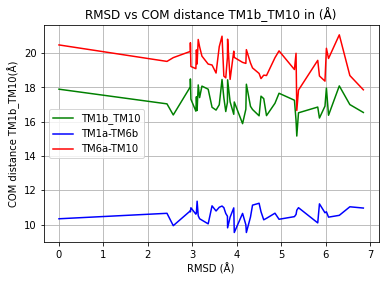

In [ ]:
s1=ser_disT_data4["TM1b_TM10"]
t1= ser_disT_data4["rmsd4"]
s2=ser_disT_data4["TM1a-TM6b"]
t2= ser_disT_data4["rmsd4"]
s3=ser_disT_data4["TM6a-TM10"]
t3= ser_disT_data4["rmsd4"]
fig, ax = plt.subplots()
ax.plot(t1, s1, color='green',label='TM1b_TM10')
ax.plot(t1, s2,color='blue', label="TM1a-TM6b")
ax.plot(t1, s3,color='red', label="TM6a-TM10" )
ax.legend()
ax.set(xlabel='RMSD (Å)', ylabel='COM distance TM1b_TM10(Å)',
       title='RMSD vs COM distance TM1b_TM10 in (Å)')
ax.grid()

#fig.savefig("test.png")
plt.show()


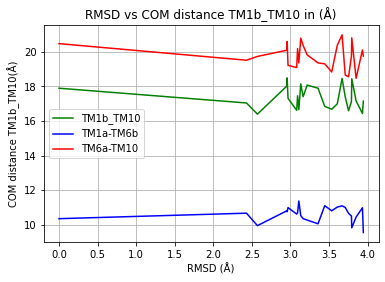

In [ ]:
s1=rmsd_data4["TM1b_TM10"]
t1= rmsd_data4["rmsd4"]
s2=rmsd_data4["TM1a-TM6b"]
t2= rmsd_data4["rmsd4"]
s3=rmsd_data4["TM6a-TM10"]
t3=rmsd_data4["rmsd4"]
fig, ax = plt.subplots()
ax.plot(t1, s1, color='green',label='TM1b_TM10')
ax.plot(t1, s2,color='blue', label="TM1a-TM6b")
ax.plot(t1, s3,color='red', label="TM6a-TM10" )
ax.legend()
ax.set(xlabel='RMSD (Å)', ylabel='COM distance TM1b_TM10(Å)',
       title='RMSD vs COM distance TM1b_TM10 in (Å)')
ax.grid()

#fig.savefig("test.png")
plt.show()

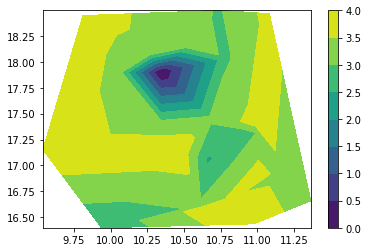

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri


y = rmsd_data4["TM1b_TM10"]
x = rmsd_data4["TM1a-TM6b"]
z = rmsd_data4["rmsd4"]


triang = mtri.Triangulation(x, y)
plt.tricontourf(triang, z)
plt.colorbar()
plt.show()

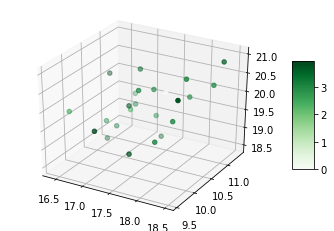

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
#zline = rmsd_data4["TM6a-TM10"]
#xline = rmsd_data4["TM1b_TM10"]
#yline = rmsd_data4["TM1a-TM6b"]
#ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = rmsd_data4["TM6a-TM10"]
xdata = rmsd_data4["TM1b_TM10"]
ydata = rmsd_data4["TM1a-TM6b"]
wdata = rmsd_data4["rmsd4"]
surf=ax.scatter3D(xdata, ydata, zdata, c=wdata, cmap='Greens');
fig.colorbar(surf, shrink=0.5, aspect=5)